# The Music of the Sphere: 100 Posterior Sample Planck CMB Temperature Maps, and their Spherical Harmonic Decompositions

*Phil Marshall, Roger Blandford, Ingunn Kathrine Wehus and Hans Kristian Eriksen, August 2015*

In this notebook we download 100 posterior sample Commander Planck CMB temperature maps, decompose them into spherical harmonics, and look at the statistics of the first few components.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import beatbox
import healpy as hp
import os.path
import glob
import numpy as np
import corner

## 1. Unpacking the Samples

Lets download the tarball containing 100 posterior sample ["COMMANDER-Ruler"](http://wiki.cosmos.esa.int/planckpla/index.php/CMB_and_astrophysical_component_maps#COMMANDER-Ruler) low resolution maps. It's 574Mb in size, so might take a few minutes to download.

In [ ]:
tarball = "commander_32band_Clsamples100.tar.gz"
datadir = "data/commander_32band_Clsamples100/"

if not os.path.isfile(tarball):
    URL = "http://folk.uio.no/ingunnkw/planck/32band/"+tarball
    !wget -O "$tarball" "$URL"
    !tar xvfz "$tarball"
    !mkdir -p "$datadir"
    !mv cmb_Cl_c000*.fits "$datadir"

Good. Now, let's read each T map in to a "beatbox" Universe model, decompose it into spherical harmonics, and write out and visualize the lowest 10 l-modes.

In [ ]:
Tmapfiles = glob.glob(datadir+"cmb_Cl_c000*.fits")
Nmaps = len(Tmapfiles)
We = np.array([]) # We are now legion!

for k in range(Nmaps):
    We = np.append(We,beatbox.Universe())
    We[k].read_in_CMB_T_map(from_this=Tmapfiles[k])
    We[k].decompose_T_map_into_spherical_harmonics()
    # We[k].show_lowest_spherical_harmonics_of_CMB_T_map(lmax=10,max=100)
    We[k].write_out_spherical_harmonic_coefficients(lmax=10)
    
# Package up alm's for Roger:
# ! cd data ; zip -r commander_32band_Clsamples100_alms.zip commander_32band_Clsamples100/*txt ; cd -

In [8]:
print "Read in",Nmaps,"maps into",len(We),"beatbox universe objects."

Read in 100 maps into 100 beatbox universe objects.


Let's take a look at one or two of the samples:

Displaying sky map of the l =  10  and lower spherical harmonics only...
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/Users/Peanuts/miniconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


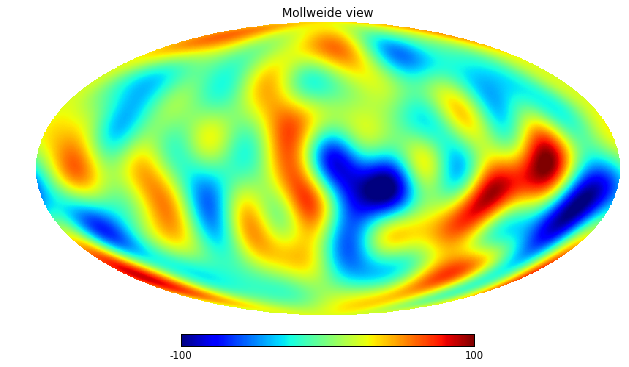

In [9]:
k = 53
We[k].show_lowest_spherical_harmonics_of_CMB_T_map(lmax=10,max=100)

Displaying sky map of the l =  10  and lower spherical harmonics only...
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


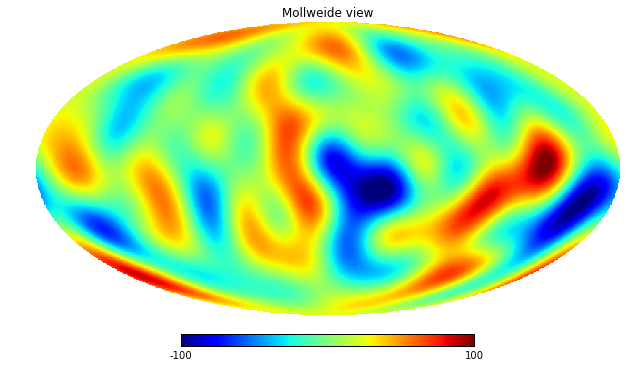

In [10]:
k = 37
We[k].show_lowest_spherical_harmonics_of_CMB_T_map(lmax=10,max=100)

Displaying sky map of the l =  10  and lower spherical harmonics only...
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


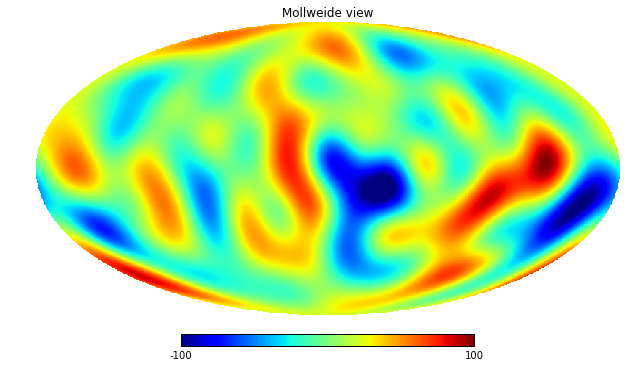

In [11]:
k = 7
We[k].show_lowest_spherical_harmonics_of_CMB_T_map(lmax=10,max=100)

Variations are noticeable but slight - Planck took *great* data.

## 2. Statistics of the Spherical Harmonics

For a weighted potential inversion, assuming a multivariate Gaussian distribution of coefficients, we would need the covariance matrix of the `alm`'s. Let's compute that and see how correlated they are.

In [9]:
mean_alm = We[0].alm*0.0
sumsq_alm = We[0].alm*0.0
for k in range(Nmaps):
    mean_alm += We[k].alm
    sumsq_alm += We[k].alm*We[k].alm
mean_alm /= float(Nmaps)
variance_alm = (sumsq_alm - Nmaps*mean_alm*mean_alm)/float(Nmaps-1)

In [10]:
print mean_alm[0:4]
print variance_alm[0:4]

[ 15.08325588+0.j   1.15907506+0.j  11.66303590+0.j  -5.62611248+0.j]
[ 0.72229212+0.j  0.00574902+0.j  0.77986594+0.j  0.02078598+0.j]


OK, they look sensible - but they're all real. I think this is just because `healpy` keeps all the m=0 modes at the beginning of the `alm` array. Let's check that the `mean_alm` gives a sensible posterior mean map.

Displaying sky map of the l =  10  and lower spherical harmonics only...
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


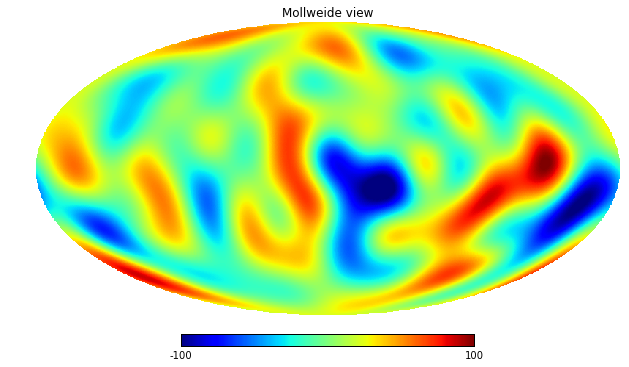

In [11]:
Lets = beatbox.Universe()
Lets.NSIDE = 256
Lets.alm = mean_alm
Lets.lmax = hp.Alm.getlmax(len(mean_alm))
Lets.show_lowest_spherical_harmonics_of_CMB_T_map(lmax=10,max=100)

Good: the `mean_alm` map looks like one of the sample maps.

Now, let's give Universe object a covariance matrix as well as an `alm` array. To be able to make maps out of the `alm` array, we need to follow the `healpy` convention for indexing it. However, for sanity, the covariance matrix needs to be in "natural" order. So, let's define an `ordered_alm` array, that matches the covariance matrix. First though, it would be good to check the Gaussian assumption we're about to make, by plotting the correlations between the first 10 coefficients (ie the positive `m`'s up to and including `l`=3.

ValueError: It looks like the parameter(s) in column(s) 0, 1, 3, 6 have no dynamic range. Please provide a `range` argument.

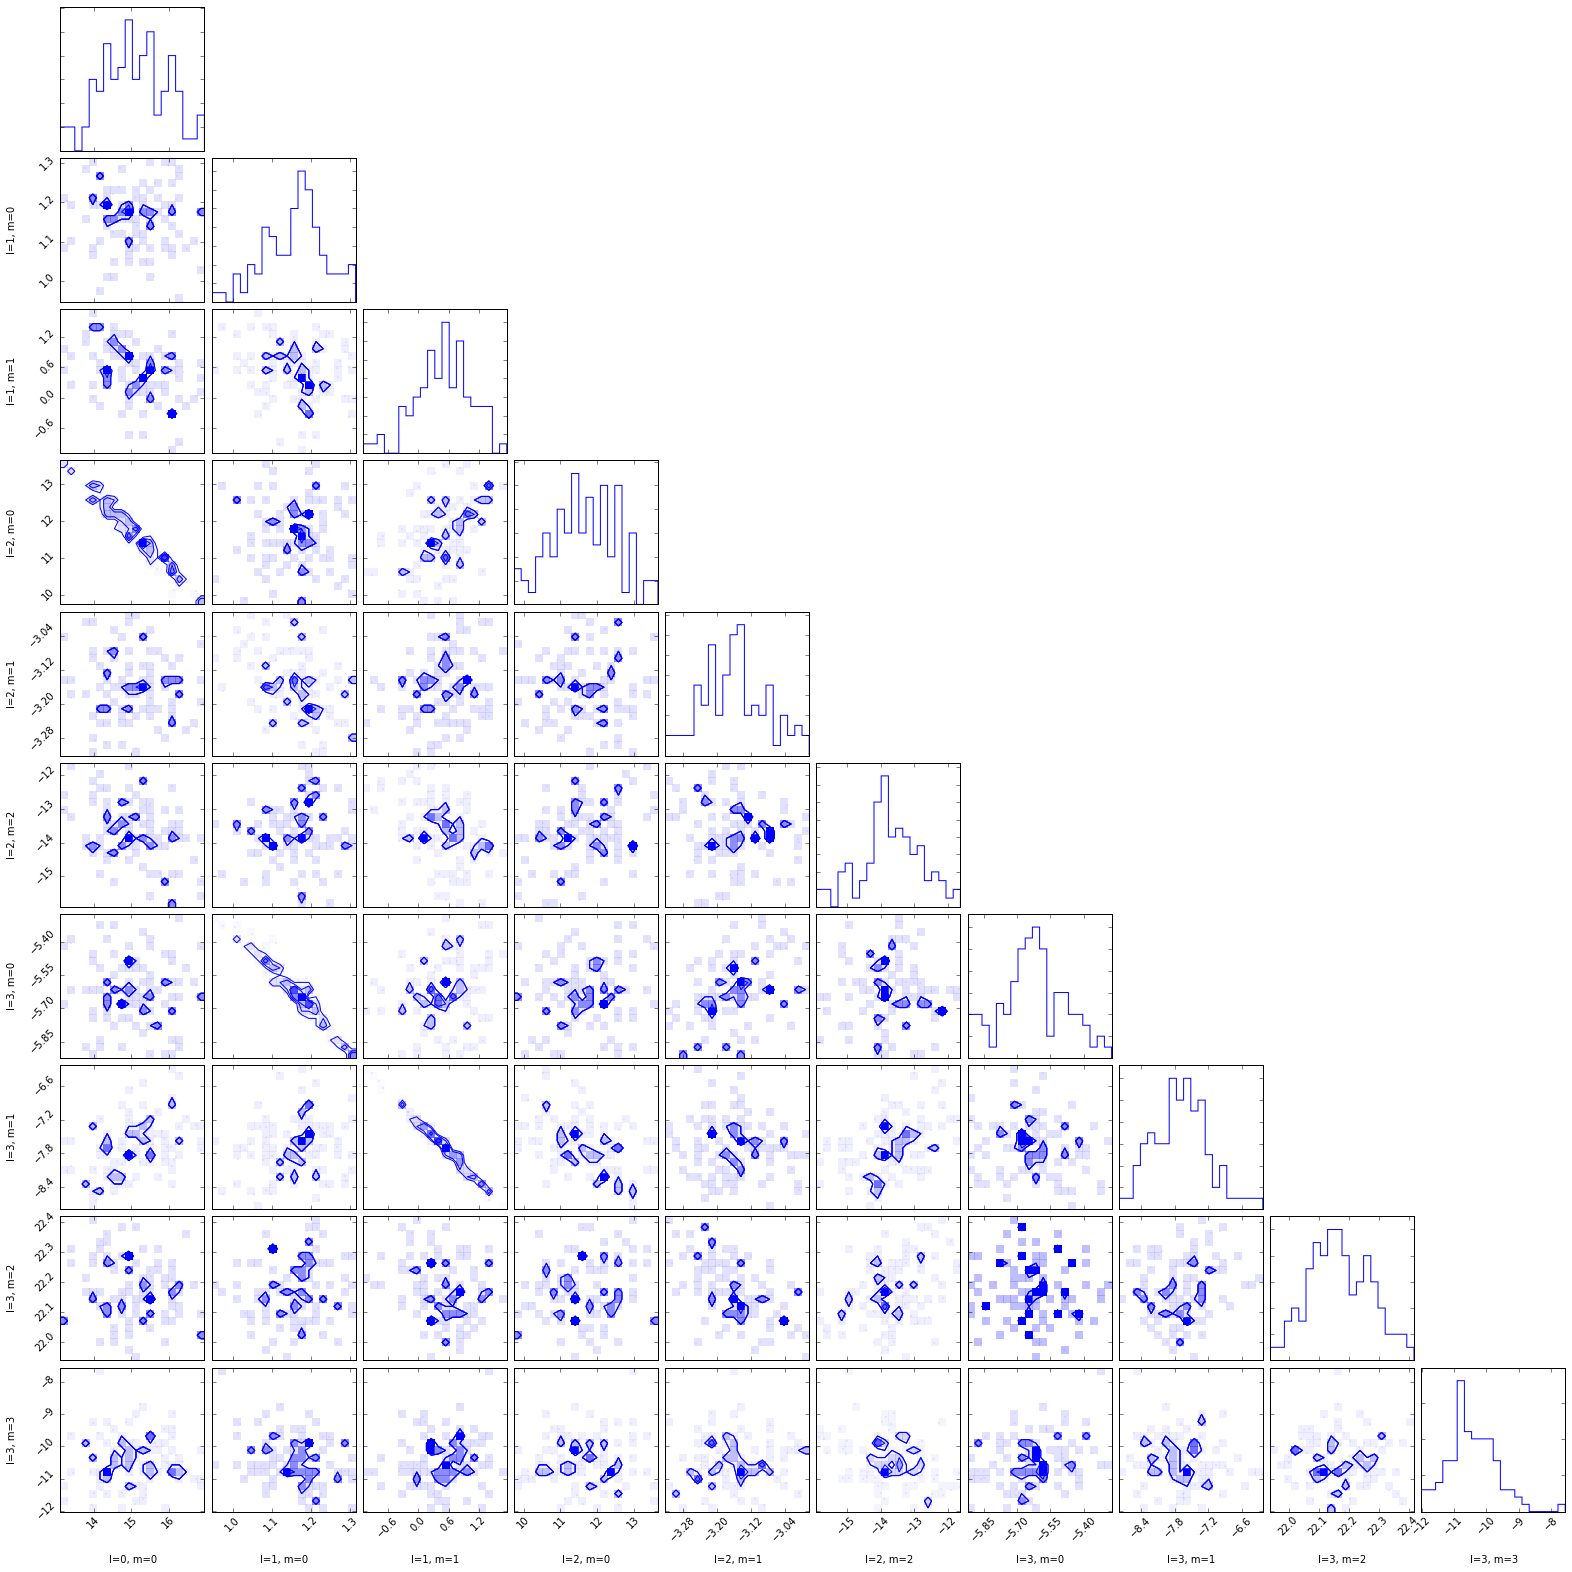

In [12]:
realplot = np.zeros([10,len(We)])
imagplot = np.zeros([10,len(We)])
text = []
lm = 0
for l in [0,1,2,3]:
    for m in range(l+1):
        i = hp.Alm.getidx(We[0].lmax, l, m)
        realcolumn = np.array([])
        imagcolumn = np.array([])
        for Tmap in We:
            realcolumn = np.append(realcolumn,np.real(Tmap.alm[i]))
            imagcolumn = np.append(imagcolumn,np.imag(Tmap.alm[i]))
        realplot[lm,:] = realcolumn
        imagplot[lm,:] = imagcolumn
        text.append('l={0:d}, m={1:d}'.format(l,m))
        lm += 1

fig = corner.corner(realplot.transpose(),labels=text,color='Blue')
_   = corner.corner(imagplot.transpose(),labels=text,color='Red',fig=fig)

Interesting: multivariate Gaussian looks like a reasonable model for the uncertainties in the Planck `alm`'s, but there are some strong degeneracies between coefficients. For example, the real part of the `l=3,m=0` coefficient is strongly anticorrelated with the real part of the `l=1,m=0` coefficient. Likewise for the `l=0,m=0` and `l=2,m=0` coefficients, and the `l=1,m=1` and `l=3,m=1` coefficients. The imaginary parts didn't plot because the `m=0` components are all zero. This *might* cause problems when we construct the covariance matrix... (We *could* just keep the real parts of the `m=0` coefficients - it seems vain to do anything else, in fact. But the book-keeping will be easier...)

In [13]:
lmax = 10
size = hp.Alm.getsize(lmax)
mean_ordered_alm = np.zeros(size,dtype=complex)
variance_of_ordered_alm = np.zeros(size,dtype=complex)

# Complex covariance matrix:
ordered_data = np.zeros([size,len(We)],dtype=complex)
# Floating point covariance matrix, with real/imaginary parts interleaved:
ms = np.zeros(2*size)
separated_data = np.zeros([2*size,len(We)])
# As above but with m=0 imaginary parts ignored: 
me = np.zeros(2*size-lmax-1)
edited_separated_data = np.zeros([2*size-lmax-1,len(We)])

i,j,k = 0,0,0
for l in range(lmax+1):
    for m in range(l+1):        
        index = hp.Alm.getidx(We[0].lmax, l, m)
        x = np.array([])
        for Tmap in We:
            x = np.append(x,Tmap.alm[index])        
        # x is now an array of 100 a(l=l1,m=m1) coefficients.
        # Take the mean, and then add a column to the data table:
        mean_ordered_alm[i] = np.mean(x)
        variance_of_ordered_alm[i] = np.var(x,ddof=1) 
        ordered_data[i,:] = x
        # Now the real/imaginary separated data:
        ms[j] = np.real(mean_ordered_alm[i])
        separated_data[j,:] = np.real(x)
        j += 1
        ms[j] = np.imag(mean_ordered_alm[i])
        separated_data[j,:] = np.imag(x)
        j += 1
        # And now the edited version:
        me[k] = np.real(mean_ordered_alm[i])
        edited_separated_data[k,:] = np.real(x)
        k += 1
        if m > 0:
            me[k] = np.imag(mean_ordered_alm[i])
            edited_separated_data[k,:] = np.imag(x)
            k += 1
        i += 1
        
assert i == size
assert j == size*2
assert k == size*2 - lmax - 1

# Now compute the covariance matrices:
C = np.cov(ordered_data)
Cs = np.cov(separated_data)
Ce = np.cov(edited_separated_data)

In [14]:
# Check the diagonal elements:
k = 23
print C[k,k],variance_of_ordered_alm[k]
print Cs[2*k,2*k],Cs[2*k+1,2*k+1]

(0.861533242372+0j) (0.861533242372+0j)
0.516282770216 0.345250472156


Pretty different result: separating data allows for covariance between real and imaginary parts to be captured, and avoids the complex products (that made all the diagonal elements pure real, for example...)

In [15]:
# Check the off-diagonal elements. 
#   l=1,m=1 vs l=3,m=2 real part should be small. k1 = 2, k2 = 8
#   l=1,m=1 vs l=3,m=1 real part should be large and negative.  k1 = 2, k2 = 7
k1,k2 = 2,8
print k1,k2,C[k1,k2],Cs[2*k1,2*k2]

k1,k2 = 2,7
print k1,k2,C[k1,k2],Cs[2*k1,2*k2]

2 8 (-0.0133256114947-0.0271507443587j) -0.0123777460626
2 7 (-0.805280624271-0.00196924926733j) -0.262797762843


OK. Let's plot the covariance matrix to see how big the elements get, and to look for any trends. There's a very nice example of how to do this by Michael Waskom [here](http://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html).

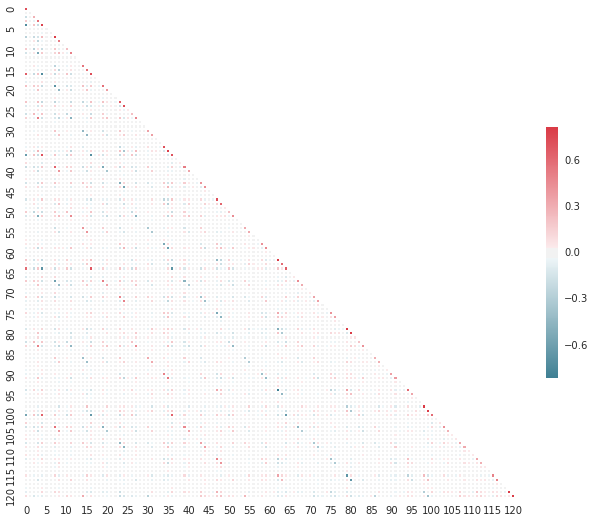

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a mask for the upper triangle
mask = np.zeros_like(Ce, dtype=np.bool)
mask[np.triu_indices_from(mask,k=1)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot the covariance matrix as a heatmap with correct aspect ratio
sns.heatmap(Ce, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

Cool - no trends with higher multipoles, and some interesting patterns between modes. Now write out the covariance matrices for Roger to play with...

In [17]:
mean_real_ordered_alm_file = 'data/commander_32band_Clsamples100_mean_real_ordered_alm.txt'
np.savetxt(mean_real_ordered_alm_file, np.real(mean_ordered_alm), fmt='%g', delimiter=',')

mean_imag_ordered_alm_file = 'data/commander_32band_Clsamples100_mean_imag_ordered_alm.txt'
np.savetxt(mean_imag_ordered_alm_file, np.imag(mean_ordered_alm), fmt='%g', delimiter=',')

covariance_real_ordered_alm_file = 'data/commander_32band_Clsamples100_cov_real_ordered_alm.txt'
np.savetxt(covariance_real_ordered_alm_file, np.real(C), fmt='%g', delimiter=',')

covariance_imag_ordered_alm_file = 'data/commander_32band_Clsamples100_cov_imag_ordered_alm.txt'
np.savetxt(covariance_imag_ordered_alm_file, np.imag(C), fmt='%g', delimiter=',')

mean_separated_file = 'data/commander_32band_Clsamples100_mean_separated.txt'
np.savetxt(mean_separated_file, ms, fmt='%g', delimiter=',')
    
covariance_separated_file = 'data/commander_32band_Clsamples100_cov_separated.txt'
np.savetxt(covariance_separated_file, Cs, fmt='%g', delimiter=',')

mean_edited_separated_file = 'data/commander_32band_Clsamples100_mean_edited_separated.txt'
np.savetxt(mean_edited_separated_file, me, fmt='%g', delimiter=',')
    
covariance_edited_separated_file = 'data/commander_32band_Clsamples100_cov_edited_separated.txt'
np.savetxt(covariance_edited_separated_file, Ce, fmt='%g', delimiter=',')


Good! The "mean_real" and "mean_imag" files are both 66-row single-column plain text files, one component of one complex `alm` coefficient per row. The first row is `(l,m)=(0,0)`, and then the ordering is `(1,0), (1,1), (2,0), (2,1)` and so on. Note that only positive `m` coefficients are stored (because the negative ones can be constructed from the positive ones. Here are the first 5 rows of the "real" file:
```
15.0532
1.16298
0.497046
11.6883
-3.15887
```
and the "imag" file:
```
0
0
2.07502
0
7.51424
```
The covariance matrix follows the same convention: only positive `m`'s, same row ordering. Each row of the two covariance matrix files (again, "real" and "imag") contains 66 columns, separated by commas, to make a square matrix. Here are the first five columns of each of the first two rows of the "real" file:
```
0.70661,-0.000257079,-0.196913,-0.72063,-0.00860671
-0.000257079,0.00558873,-0.00799419,-0.00458422,-0.00229347
```
and the "imag" one:
```
0,0,-0.193608,0,-0.0274199
0,0,-0.0264061,0,-0.00193331
```


Meanwhile, the "separated" mean file is also a single column ascii plain text file, but is twice the length (132 rows) and has the real and imaginary parts interleaved:
```
15.0532
0
1.16298
0
0.497046
2.07502
11.6883
0
-3.15887
7.51424
```
The corresponding "separated" covariance matrix file also has 132 rows, and also follows the real-imag-real-imag interleaving:
```
0.70661,0,-0.000257079,0, ...
0,0,0,0, ...
-0.000257079,0,0.00558873,0, ...
0,0,0,0, ...
```
This matrix contains a lot of zero rows and columns, corresponding to the imaginary parts of the `m=0` coefficients. We'd better check the condition number.


The "edited_separated" files are like the "separated" ones, but with the imaginary parts of the `m=0` coefficients removed. This means there are `2*66-11=121` rows in each of them.

In [18]:
print "Cs condition number = ",np.linalg.cond(Cs)
import sys
print "Largest meaningful float = ", 1.0/sys.float_info.epsilon

Cs condition number =  1.11196141864e+33
Largest meaningful float =  4.50359962737e+15


This is bad news. Try the edited version:

In [19]:
print "Ce condition number = ",np.linalg.cond(Ce)
print "Largest meaningful float = ", 1.0/sys.float_info.epsilon

Ce condition number =  3.5437808698e+18
Largest meaningful float =  4.50359962737e+15


Hmm. The `Ce` matrix still looks ill-conditioned, which might still be a problem. The complex covariance matrix is fine, by the way: 

In [20]:
np.linalg.cond(C),np.linalg.cond(np.real(C)),np.linalg.cond(np.imag(C))

(2278104.7689008913, 318369.29415541346, 860539.85951048369)

Let's try using the edited mean and covariance matrix in a potential reconstruction anyway, and see what happens. We'll need the inverse of the covariance matrix - and since its ill-conditioned, the pseudo-inverse is a better bet.

In [21]:
Ceinv = np.linalg.pinv(Ce)
print Ceinv
if np.isnan(Ceinv).any(): print "Matrix contains at least one NaN"
if np.isinf(Ceinv).any(): print "Matrix contains at least one Inf"

[[  1.19401149e+04   8.10772468e+03   4.86397852e+03 ...,  -7.87205058e+01
    4.51259679e-01   8.34785520e+01]
 [  8.10772468e+03   6.12089999e+04   1.44476886e+04 ...,  -1.81112456e+02
   -1.07166669e+02   2.02500046e+02]
 [  4.86397852e+03   1.44476886e+04   5.56127367e+04 ...,  -3.76850307e+02
   -2.44919439e+02   6.52613432e+02]
 ..., 
 [ -7.87205057e+01  -1.81112456e+02  -3.76850307e+02 ...,   2.25792831e+03
    1.01973239e+02  -1.18431291e+01]
 [  4.51259693e-01  -1.07166669e+02  -2.44919439e+02 ...,   1.01973239e+02
    2.87014899e+01  -1.57236111e+01]
 [  8.34785521e+01   2.02500046e+02   6.52613432e+02 ...,  -1.18431291e+01
   -1.57236111e+01   4.83467605e+01]]


OK, that seems promising! Write out the inverse matrix for Roger.

In [22]:
inverse_covariance_edited_separated_file = 'data/commander_32band_Clsamples100_inverse_cov_edited_separated.txt'
np.savetxt(inverse_covariance_edited_separated_file, Ceinv, fmt='%g', delimiter=',')